In [1]:
import math
from scipy import integrate
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from cardano_method import CubicEquation
import sympy as sp
from sympy import re, im, E, I, symbols
import csv

In [93]:
pi = math.pi
npLogLimit = 35
q = 1.602176634e-19 # elementary charge
m0 = 9.1093837015e-31 # electron mass
mRel = 0.342 # b-Ga2O3 relative reduced electron mass 
m = mRel * m0 # b-Ga2O3 reduced electron mass
h = 6.62607015e-34 # Planck constant
hBar = h/2/pi
kB = 1.380649e-23 # Boltzmann constant
e0 = 8.8541878128e-12 # vacuum permittivity
eOpt = 3.57 # optical dielectric constant of b-Ga2O3
eSta = 10 # static dielectric constant of b-Ga2O3
T = 295 # device temperature
kT = kB*T 
Nc = 1e-6*2*(2*pi*m*kT/h**2)**1.5
n = 1.e16 # sample carrier concentration in cm-3
phiM = kT*np.log(Nc/n)/q # Ec-Ef in eV  
#phi = 1 # Barrier height in eV
A = 4*pi*q*m*kB**2/h**3 # effective Richarson constant in A/m2/K2
aOpt = q/16/pi/eOpt/e0 # coefficient a (with the negative sign, optic) in front of the 1/x term of the potential a = e/(16*pi*e)
aSta = q/16/pi/eSta/e0 # coefficient a (with the negative sign, static) in front of the 1/x term of the potential a = e/(16*pi*e)
b = q*n*1e6/2/e0/eSta # coefficient b (V/m2) in front of the quadratic term of the potential b = q*n/2e
upperIntegrationLimit = 10*kT/q
lowerIntegrationLimit = 10*kT/q
print (kT/q)
print('b: ', b*1e-18, ' aSta: ', aSta*1e9)

0.025421133123328277
b:  9.047564089863915e-06  aSta:  0.03599911369606418


In [94]:
def fF (phiB, Vr): # surface electrical field in V/m
    return ((2*q*n*1e6*(phiB-Vr-phiM-kT/q)/eSta/e0)**0.5)
def fWd (phiB, Vr): # depletion width in nm
    return ((2/q/n/1e6*(phiB-Vr-phiM-kT/q)*eSta*e0)**0.5*1e9)
def fXmax(phiB, Vr, a): # position in nm of the top of the potential barrier  
    equation = CubicEquation([2*b*1e-18,-fF(phiB,Vr)*1e-9,0,a*1e9]) # coefficients are converted so that the solutions give results in nm
    return (equation.answers[2].real) # first solution is ~ Wd, second is ~ -xmax, and third is xmax
def fEmax(phiB, Vr, a): # top of the potential barrier in eV
    x = fXmax(phiB, Vr, a)*1e-9 # convert xmax back to m
    return (phiB - fF(phiB,Vr)*x - a/x + b*x**2)
def fX1X2(W, phiB, Vr, a): # returns an array with positions x1, x2 in nm, where W and E intersect 
    # W is in V, if it is energy it would be measusred in eV
    equation = CubicEquation([b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9])# coefficients are converted so that the solutions give results in nm
#     print('Cubic equation A: ', b*1e-18, ' B: ', -fF(phiB,Vr)*1e-9, ' C: ', phiB-W, ' D: ', -a*1e9)
#     print('fX1X2 solutions: ', equation.answers)
    return ([equation.answers[1], equation.answers[2]])
    #the first solution is the far branch of the parabol, related to the bx2/2e term
    #the second and third solutions are relevant to the problem.
def fIntegrand(x, W, phiB, Vr, F, a, b): # returns function that needs to be integrated, unit is V^0.5
    # x is in nanometer, W, phiB in V, F in V/m, a V*m, b in V/m2
    y = x*1e-9 #convert x back to meter
    if W >= fEmax(phiB, Vr, a): # in this case, the energy > potential
        xCom1,xCom2 = fX1X2(W,phiB,Vr, a)
        x0 = xCom1.real*1e-9
        A = W-phiB
        #B = F
        #C = a
        #D = b
        #factor1 = ((F*y-a*y/(x0**2 + y**2)-2*b*x0*y)**2 + (A + F*x0+a*x0/(x0**2 + y**2)-b*(x0**2-y**2))**2)**0.25
        #factor2 = math.cos(math.atan2(F*y-a*y/(x0**2 + y**2)-2*b*x0*y,A + F*x0+a*x0/(x0**2 + y**2)-b*(x0**2-y**2))/2)
        result = ((F*y-a*y/(x0**2 + y**2)-2*b*x0*y)**2 + (A + F*x0+a*x0/(x0**2 + y**2)-b*(x0**2-y**2))**2)**0.25 \
                *math.cos(math.atan2(F*y-a*y/(x0**2 + y**2)-2*b*x0*y,A + F*x0+a*x0/(x0**2 + y**2)-b*(x0**2-y**2))/2)
        #print('factor1: ', factor1, ' factor2: ', factor2, ' fIntegrand: ', result)
        #this is the real path of the momentum
    else: # in this case the energy < potential
        result = (phiB-W-F*y-a/y+b*y**2)**0.5 
        # this is the pi/2 branch of the imaginary path of the momentum 
    return (result)
def fProb(W, phiB, Vr, a): # returns probability of the transition of electons with energy W (in eV in this case)
    xCom1,xCom2 = fX1X2(W,phiB,Vr, a)
    #print('xCom1:', xCom1, ' xCom2: ' ,xCom2)
    if (xCom1.real <= 0 or xCom2.real <=0): # when the energy > potential and one of the solutions is close to the sigularity
        result = 1
    else: 
        F = fF(phiB, Vr)
        if W >= fEmax(phiB, Vr, a):
            x1 = xCom1.imag
            x2 = xCom2.imag
            rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, Vr, F, a, b))[0]
            #print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W)
            try:
                result = 1/(1 + math.exp((8*m*q)**0.5/hBar*rIntegral*1e-9))
            except OverflowError:
                result = 1
            #print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W, " Prob: ", result) 
        else:
            x1 = xCom1.real
            x2 = xCom2.real
            rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, Vr, F , a, b))[0]
            try:
                result = 1/(1 + math.exp((8*m*q)**0.5/hBar*rIntegral*1e-9))
            except OverflowError:
                result = 0
            #print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W, " Prob: ", result)
    return (result)
def fDiffJ(W, phiB, Vr, a): # returns differential current density in A/cm2/eV at energy W in eV (or V)
    if (W*q/kT) < npLogLimit:    
        return (A*T/kB*fProb(W, phiB, Vr, a)*math.log(1 + np.exp(-W*q/kT))*1e-4*q)
    else: 
        return (A*T/kB*fProb(W, phiB, Vr, a)*math.exp(-W*q/kT)*1e-4*q)
def fJ(phiB, Vr, a):
    J = integrate.quad(fDiffJ, 0, phiB, args = (phiB, Vr, a))[0]
    print('Vr: ', Vr, ' J: ', J)
    return J 
def fIVCurve(arrVr, phiB, a):
    arrJ = []
    for Vr in arrVr:
        J = fJ(phiB,Vr,a)        
        arrJ.append(J)
#     fig, ax = plt.subplots()
#     ax.plot(arrVr, arrJ)
#     ax.set_yscale('log')
    return ([arrVr,arrJ])
def fReadCsv(filePath, dataRowStart = 9, colNum = 19, colFormat = True):
    with open(filePath, 'r') as csvfile:
        rowData = []
        rowIndex = 0
        for row in csvfile:
            if rowIndex >= dataRowStart-1:
                numbers_as_str = row.strip('').split(',')[0:colNum]
                rowData.append([float(num) for num in numbers_as_str])
            rowIndex+=1
        if colFormat:
            i = 0
            j = 0
            colData = [[rowData[i][j] for i in range(len(rowData))] for j in range(len(rowData[0]))]
            return colData
        else:
            return(rowData)
    
def fWriteCsv(filePath, arrHeader, arrData):
    with open (filePath, 'w', newline='') as csvfile:
        csvWriter = csv.writer(filePath)
        for row in arrHeader:
            csvWriter.writerow(row)
        for row in arrData:
            csvWriter.writerow(row)
        

In [95]:
filePath = './231210SM_Dev16_ReverseCurrent.csv'
arrData = fReadCsv(filePath, colFormat = True)

In [96]:
a = aOpt
phiB = 1.12
arrVr = np.linspace(0,-500, 6)
arrVrJ =fIVCurve(arrVr, phiB, a)

Vr:  0.0  J:  1.4816330819492857e-12
Vr:  -100.0  J:  4.746068547899842e-10
Vr:  -200.0  J:  4.87951623525117e-09
Vr:  -300.0  J:  3.755766581422092e-08
Vr:  -400.0  J:  2.722703693756587e-07
Vr:  -500.0  J:  1.891907148240309e-06


(1e-10, 0.01)

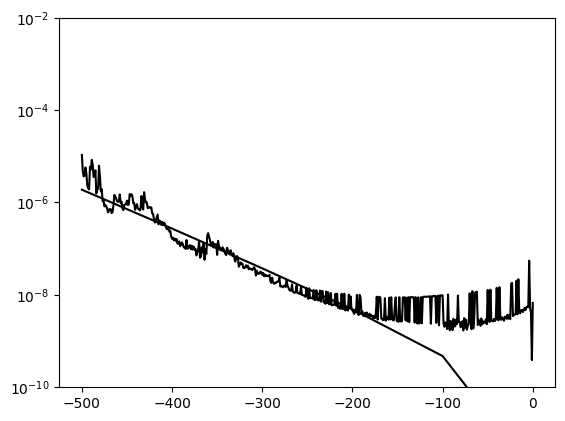

In [97]:
fig, ax = plt.subplots()
line1, = ax.plot(arrData[0], arrData[16] , color='black', linestyle = '-')
line2, = ax.plot(arrVr, arrVrJ[1] , color='black', linestyle = '-')
ax.set_yscale('log')
ax.set_ylim(1e-10, 1e-2)

Vr:  -200.0  J:  8.352355551402934e-12
Vr:  -300.0  J:  2.328077279451295e-10
Vr:  -400.0  J:  5.787403073643742e-09
Vr:  -500.0  J:  1.0086130222436591e-07


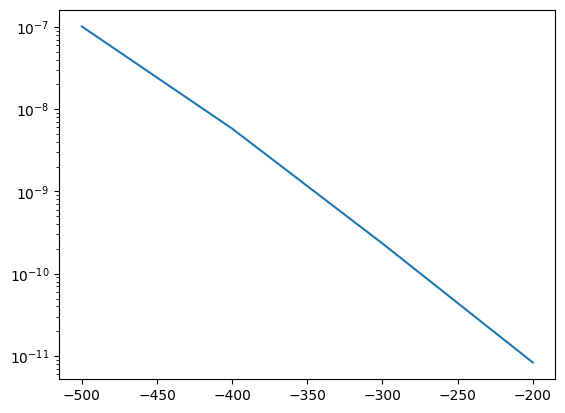

In [108]:
a = -36
print(math.log(1+math.exp(a)))
print(math.exp(a))

2.2204460492503128e-16
2.3195228302435696e-16


In [15]:
arrHeader = [['Vr', 'J'],['V', 'A/cm2']]
arrData = [-1,2]
arrHeader.append([])
arrHeader[2] = [-1,2]
print (arrHeader)

[['Vr', 'J'], ['V', 'A/cm2'], [-1, 2]]


In [205]:
phiB = 1
Vr = -250
a = aOpt
arrW = np.linspace(0.5,1.5,11)
print ('Wmax: ', fEmax(phiB,Vr,a))
for W in arrW:
    print(f'W = {W: .1f}', ' eV', ' X1, X2 = ', fX1X2(W, phiB, Vr, a))

Wmax:  0.7795346635060645
W =  0.5  eV  X1, X2 =  [(0.212567-0j), (3.938228+0j)]
W =  0.6  eV  X1, X2 =  [(0.274856-0j), (3.045429+0j)]
W =  0.7  eV  X1, X2 =  [(0.400587-0j), (2.089352+0j)]
W =  0.8  eV  X1, X2 =  [(0.82988+0.384945j), (0.82988-0.384945j)]
W =  0.9  eV  X1, X2 =  [(0.414874+0.815279j), (0.414874-0.815279j)]
W =  1.0  eV  X1, X2 =  [(-5e-05+0.914722j), (-5e-05-0.914722j)]
W =  1.1  eV  X1, X2 =  [(-0.414892+0.815168j), (-0.414892-0.815168j)]
W =  1.2  eV  X1, X2 =  [(-0.82965+0.385008j), (-0.82965-0.385008j)]
W =  1.3  eV  X1, X2 =  [(-2.088056-0j), (-0.400597+0j)]
W =  1.4  eV  X1, X2 =  [(-3.042982-0j), (-0.274857+0j)]
W =  1.5  eV  X1, X2 =  [(-3.934293-0j), (-0.212568+0j)]


3.84593
0.9473471655048877
1
[(485.40312+0j), (-3.38385+1.702978j), (-3.38385-1.702978j)]
fDiffJ:  6.34202931348223e-21


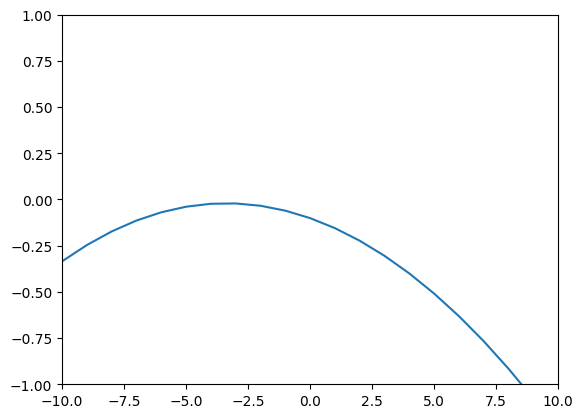

In [226]:
# #print(fF(1,-250))
a = aOpt
phiB = 1
Vr = 0
xMax = fXmax(phiB, Vr,a)
Emax = fEmax(phiB, Vr, a)
print (xMax)
print (Emax)
delW = 0.1
W = Emax + delW
X1, X2 = fX1X2(W, phiB, Vr, a)
print (fProb(W,phiB,Vr,a))

def fCubic(x, A,B,C,D):
    return (A*x**3+B*x**2+C*x+D)
arrX = np.linspace(-200, 1000, 1201)
A, B, C, D = [b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9]
equation = CubicEquation([A,B,C,D])
arrY = [fCubic(x, A, B, C, D) for x in arrX ]
fig, ax = plt.subplots()
ax.plot(arrX,arrY)
ax.set_ylim(-1,1)
ax.set_xlim(-10,10)
print(equation.answers)
print('fDiffJ: ', fDiffJ(W, phiB, Vr, a))

# print('X1: ' , X1, ' X2: ', X2)

#print (fProb(0.8682702010292268-0.025,1,-250,aSta))
#print (CubicEquation([2.8952205087564525e-05, -0.006928775412859064, 0, 0.03599911369606418]).answers)

In [209]:
# arrDelW = np.linspace(-8,0,100)
# arrDelW = 10**arrDelW
# arrDelW = np.linspace(0, phiB-Emax, 201)
arrDelW = np.linspace(-0.2, 0.2, 401)
arrProb = [fProb(Emax + delW, phiB, Vr, a) for delW in arrDelW]
print(arrDelW)
print(arrProb)

[-0.2   -0.199 -0.198 -0.197 -0.196 -0.195 -0.194 -0.193 -0.192 -0.191
 -0.19  -0.189 -0.188 -0.187 -0.186 -0.185 -0.184 -0.183 -0.182 -0.181
 -0.18  -0.179 -0.178 -0.177 -0.176 -0.175 -0.174 -0.173 -0.172 -0.171
 -0.17  -0.169 -0.168 -0.167 -0.166 -0.165 -0.164 -0.163 -0.162 -0.161
 -0.16  -0.159 -0.158 -0.157 -0.156 -0.155 -0.154 -0.153 -0.152 -0.151
 -0.15  -0.149 -0.148 -0.147 -0.146 -0.145 -0.144 -0.143 -0.142 -0.141
 -0.14  -0.139 -0.138 -0.137 -0.136 -0.135 -0.134 -0.133 -0.132 -0.131
 -0.13  -0.129 -0.128 -0.127 -0.126 -0.125 -0.124 -0.123 -0.122 -0.121
 -0.12  -0.119 -0.118 -0.117 -0.116 -0.115 -0.114 -0.113 -0.112 -0.111
 -0.11  -0.109 -0.108 -0.107 -0.106 -0.105 -0.104 -0.103 -0.102 -0.101
 -0.1   -0.099 -0.098 -0.097 -0.096 -0.095 -0.094 -0.093 -0.092 -0.091
 -0.09  -0.089 -0.088 -0.087 -0.086 -0.085 -0.084 -0.083 -0.082 -0.081
 -0.08  -0.079 -0.078 -0.077 -0.076 -0.075 -0.074 -0.073 -0.072 -0.071
 -0.07  -0.069 -0.068 -0.067 -0.066 -0.065 -0.064 -0.063 -0.062 -0.061
 -0.06

Text(0, 0.5, 'Transmission Probability')

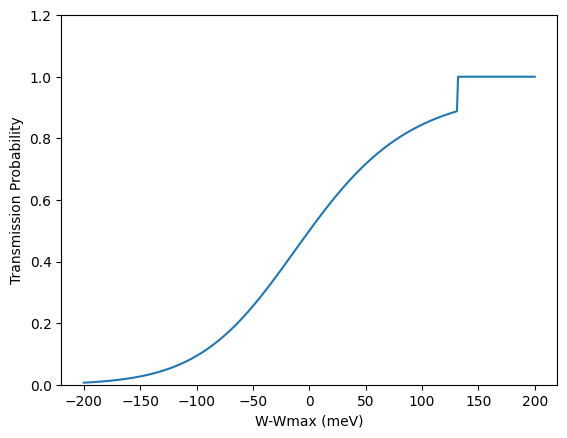

In [210]:
fig, ax = plt.subplots()
ax.plot(arrDelW*1e3, arrProb)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_ylim(0,1.2)
plt.xlabel("W-Wmax (meV)")
plt.ylabel("Transmission Probability")

In [218]:
arrMDelW = np.linspace(0, -0.2, 201) # array of different in eV from the top of the potential
arrMProb = [fProb(Emax + delW, phiB, Vr, a) for delW in arrMDelW] 
print (arrMDelW)

[ 0.    -0.001 -0.002 -0.003 -0.004 -0.005 -0.006 -0.007 -0.008 -0.009
 -0.01  -0.011 -0.012 -0.013 -0.014 -0.015 -0.016 -0.017 -0.018 -0.019
 -0.02  -0.021 -0.022 -0.023 -0.024 -0.025 -0.026 -0.027 -0.028 -0.029
 -0.03  -0.031 -0.032 -0.033 -0.034 -0.035 -0.036 -0.037 -0.038 -0.039
 -0.04  -0.041 -0.042 -0.043 -0.044 -0.045 -0.046 -0.047 -0.048 -0.049
 -0.05  -0.051 -0.052 -0.053 -0.054 -0.055 -0.056 -0.057 -0.058 -0.059
 -0.06  -0.061 -0.062 -0.063 -0.064 -0.065 -0.066 -0.067 -0.068 -0.069
 -0.07  -0.071 -0.072 -0.073 -0.074 -0.075 -0.076 -0.077 -0.078 -0.079
 -0.08  -0.081 -0.082 -0.083 -0.084 -0.085 -0.086 -0.087 -0.088 -0.089
 -0.09  -0.091 -0.092 -0.093 -0.094 -0.095 -0.096 -0.097 -0.098 -0.099
 -0.1   -0.101 -0.102 -0.103 -0.104 -0.105 -0.106 -0.107 -0.108 -0.109
 -0.11  -0.111 -0.112 -0.113 -0.114 -0.115 -0.116 -0.117 -0.118 -0.119
 -0.12  -0.121 -0.122 -0.123 -0.124 -0.125 -0.126 -0.127 -0.128 -0.129
 -0.13  -0.131 -0.132 -0.133 -0.134 -0.135 -0.136 -0.137 -0.138 -0.139
 -0.14

Text(0, 0.5, 'Transmission Probability')

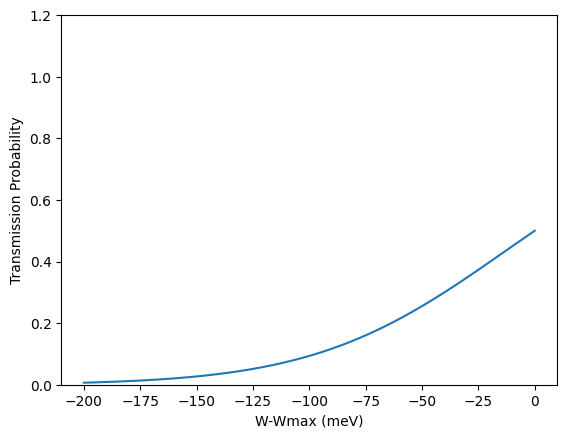

In [186]:
fig, ax = plt.subplots()
ax.plot(arrMDelW*1e3, arrMProb)
ax.set_yscale('linear')
ax.set_ylim(0,1.2)
plt.xlabel("W-Wmax (meV)")
plt.ylabel("Transmission Probability")

In [227]:
arrW = np.linspace(0, phiB+upperIntegrationLimit, 1001)
arrDiffJ = [(fDiffJ(W, phiB, Vr, a)) for W in arrW]

Text(0, 0.5, 'Differential Current Density (A/cm2/eV)')

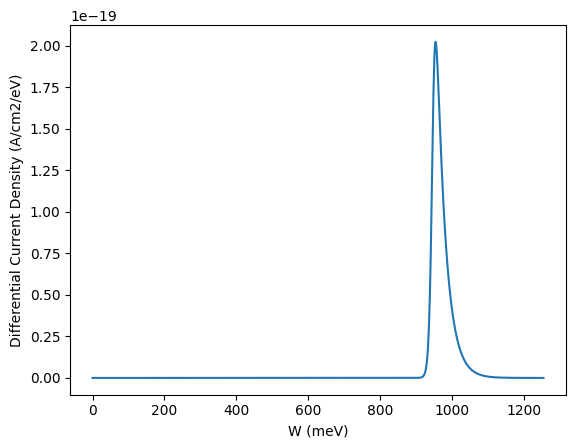

In [231]:
fig1, ax1 = plt.subplots()
ax1.plot(arrW*1e3, arrDiffJ)
ax1.set_yscale('linear')
#ax1.set_ylim(1e-20, 1e-15)
plt.xlabel("W (meV)")
plt.ylabel("Differential Current Density (A/cm2/eV)")

In [68]:
# Results if use boundaries x1, x2 in meter. Do NOT remove or delete this cell 
print(fProb(0.5,1,0, aOpt))

2.3028964723790233e-102


In [122]:
print(fX1X2(0.74, 1, -250, aOpt))

[(8323.012351-0j), (0.50696-0j), (1.650888+0j)]


In [40]:
print (fIntegrand(1e-9,0.5, 1, fF(1,-500),aOpt, b))

nan


/tmp/ipykernel_1187/1361195881.py:18: RuntimeWarning: invalid value encountered in scalar power
  return ((phiB-W-F*y-a/y+b*y**2)**0.5)


In [28]:
# Do NOT remove, change or delete this cell
# Results if use boundaries x1, x2 in meter. 
# Return values in V^0.5*m 
print(fProb(0.5,1,-250, aOpt))

(1.4678359700848055e-09, 1.8292215760113234e-10)


In [83]:
A, F, a, b = symbols('A F a b', real=True)
x0, y = symbols('x0 y', real = True)
re(sp.sqrt(A+F*(x0+I*y)+a/(x0+I*y)-b*(x0+I*y)**2))

((F*y - a*y/(x0**2 + y**2) - 2*b*x0*y)**2 + (A + F*x0 + a*x0/(x0**2 + y**2) - b*(x0**2 - y**2))**2)**(1/4)*cos(atan2(F*y - a*y/(x0**2 + y**2) - 2*b*x0*y, A + F*x0 + a*x0/(x0**2 + y**2) - b*(x0**2 - y**2))/2)

In [31]:
# Do NOT remove, change or delete this cell
# Results if use boundaries x1, x2 in meter. 
# Return values in V^0.5*nm
print(fProb(0.5,1,-250, aOpt))

(1.4677740848306249, 9.521495369924082e-09)


In [148]:
print (math.log(math.exp(1)), " ", math.exp(1))

1.0   2.718281828459045


[(488.33423-0j), (-9.14176-0j), (-0.557051+0j)]


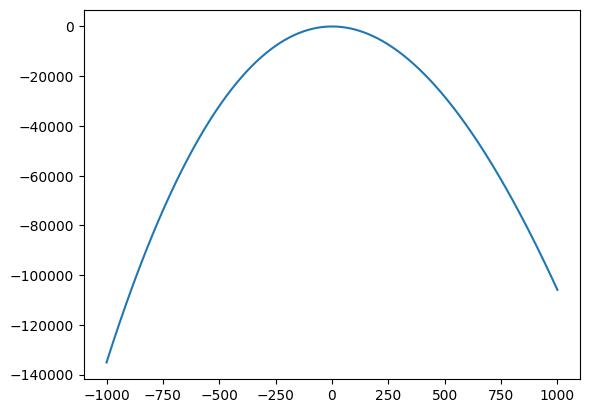

In [29]:
equation = CubicEquation([1.4476102543782263e-05, -0.006928775412859064, -0.06848888185948465, -0.03599911369606418])
def fCubic(x, A,B,C,D):
    return (A*x**3+B*x**2+C*x+D)
arrX = np.linspace(-1000, 1000, 2001)
A, B, C, D = [b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9]
arrY = [fCubic(x, A, B, C, D) for x in arrX ]
plt.plot(arrX,arrY)
print(equation.answers)

In [59]:
#print(fF(1,0))
# arrV = -np.linspace(1, 4000, 4001) # array of different in eV from the top of the potential
# #arrF = [(fF(1.4, V)*1e-8) for V in arrV] # in MV/cm
# #arrJ = [(fJ(1.4, V, aSta)) for V in arrV] # in A/cm2 
# #print(fJ(1.4, -200, aSta))
#print(fXmax(1,-250,aOpt))
#print(fEmax(1, 0, aOpt))
#print(fProb(0.948, 1, 0, aOpt))
# def fX1X2(W, phiB, Vr, a): # returns an array with positions x1, x2 in nm, where W and E intersect 
#     # W is in V, if it is energy it would be measusred in eV
#     equation = CubicEquation([b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9])# coefficients are converted so that the solutions give results in nm
#     return ([equation.answers[1].real, equation.answers[2].real])
x1,x2 = fX1X2(0.8,1,-250, aOpt)
print(fX1X2(0.8,1,-250, aOpt), " ", x1.imag)
print(fProb(0.8, 1, -250, aOpt))

[(0.82988+0.384945j), (0.82988-0.384945j)]   0.384945
(0.82988+0.384945j) (0.82988-0.384945j)
factor1  155.0059868459205  factor2  -0.7071064646269344  fIntegrand  -109.60573535462794
factor1  155.00598553368857  factor2  -0.7071067676456  fIntegrand  -109.60578139644716
factor1  155.0059881580904  factor2  -0.7071067676456004  fIntegrand  -109.6057832521795
factor1  155.00598083515  factor2  -0.7071067125690996  fIntegrand  -109.60576953689178
factor1  155.00599285663154  factor2  -0.7071067125691102  fIntegrand  -109.6057780373637
factor1  155.0059761543054  factor2  -0.7071066261497311  fIntegrand  -109.60575283151655
factor1  155.00599753748764  factor2  -0.7071066261497737  fIntegrand  -109.60576795171302
factor1  155.00597596772695  factor2  -0.7071065340746981  fIntegrand  -109.60573842740536
factor1  155.005997724089  factor2  -0.7071065340747674  fIntegrand  -109.60575381148188
factor1  155.00598218626365  factor2  -0.7071064731122916  fIntegrand  -109.60573337503558
factor1  

Text(0, 0.5, 'Transmission Probability')

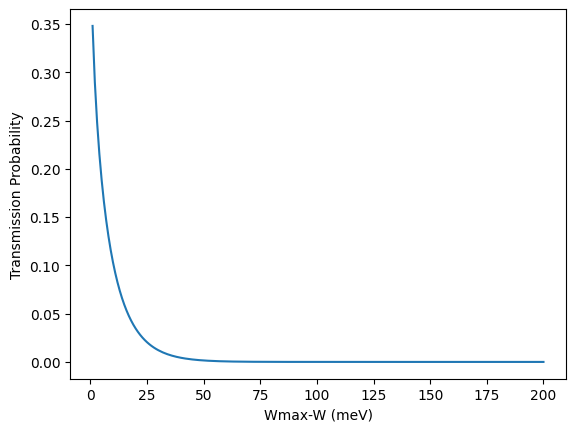

In [80]:
fig, ax = plt.subplots()
ax.plot(arrDelW*1e3, arrProb)
ax.set_yscale('linear')
plt.xlabel("Wmax-W (meV)")
plt.ylabel("Transmission Probability")

In [34]:
!pip list

Package                   Version
------------------------- ------------
anyio                     4.2.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
beautifulsoup4            4.12.2
bleach                    4.1.0
Brotli                    1.0.9
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        2.0.4
comm                      0.2.1
contourpy                 1.2.0
cycler                    0.11.0
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
executing                 0.8.3
fastjsonschema            2.16.2
fonttools                 4.25.0
idna                      3.4
ipykernel                 6.28.0
ipython                   8.20.0
ipywidgets                8.1.2
jedi                      0.18.1
Jinja2                    3.1.3
json5             